# Exercise 2d
First we import the libraries we need from exercise 2b and 2c:

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from PIL import Image
from os import listdir
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import time


# PyTorch libraries and modules
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

Next, we load the images (you might have to adjust the paths here):

In [20]:
# benno
train_folder_normal = "C:/Users/bennx/OneDrive/Desktop/mnist-png-format/train/"
test_folder_normal = "C:/Users/bennx/OneDrive/Desktop/mnist-png-format/test/"

train_folder_perm = "C:/Users/bennx/OneDrive/Desktop/mnist-png-format-permutated/train/"
test_folder_perm = "C:/Users/bennx/OneDrive/Desktop/mnist-png-format-permutated/test/"

def load_images(folder_path):
    data = {int(s): [np.asarray(Image.open(f"{folder_path}/{s}/{p}")).reshape(-1, )
        for p in listdir(f"{folder_path}{s}")
    ] for s in listdir(folder_path)}

    (ys, xs) = reduce(
        lambda a, b: (a[0] + [b[0]]*len(b[1]), a[1] + b[1]),
        data.items(),
        ([], [])
    )

    return np.array(ys), np.array(xs)

y_testn, x_testn = load_images(test_folder_normal)
y_trainn, x_trainn = load_images(train_folder_normal)

y_testp, x_testp = load_images(test_folder_perm)
y_trainp, x_trainp = load_images(train_folder_perm)

print(f"Shape of x_trainn: {x_trainn.shape}; shape of y_trainn: {y_trainn.shape}.")
print(f"Shape of x_testn: {x_testn.shape}; shape of y_testn: {y_testn.shape}.")
print(f"Shape of x_trainp: {x_trainp.shape}; shape of y_trainp: {y_trainp.shape}.")
print(f"Shape of x_testp: {x_testp.shape}; shape of y_testp: {y_testp.shape}.")

Shape of x_trainn: (60000, 784); shape of y_trainn: (60000,).
Shape of x_testn: (10000, 784); shape of y_testn: (10000,).
Shape of x_trainp: (60000, 784); shape of y_trainp: (60000,).
Shape of x_testp: (10000, 784); shape of y_testp: (10000,).


Since we did already the optimization in 2b, we take 100 neurons, learning rate 0.001 and 200 maximal iterations (divided in 20 times 10 iterations):

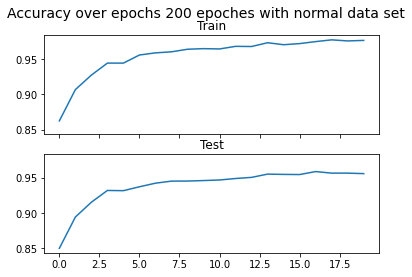

In [21]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=10)

N_TRAIN_SAMPLES = x_trainn.shape[0]
N_EPOCHS = 20
N_BATCH = 128
N_CLASSES = np.unique(y_trainn)

acc_train = []
acc_test = []

epoch = 0
while epoch < N_EPOCHS:
    random_perm = np.random.permutation(x_trainn.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        mlp.partial_fit(x_trainn[indices], y_trainn[indices], classes=N_CLASSES)
        mini_batch_index += N_BATCH
        if mini_batch_index >= N_TRAIN_SAMPLES:
            break

    acc_train.append(mlp.score(x_trainn, y_trainn))
    acc_test.append(mlp.score(x_testn, y_testn))
    epoch += 1


fig, ax = plt.subplots(2, sharex=True, sharey=True)
ax[0].plot(acc_train)
ax[0].set_title('Train')
ax[1].plot(acc_test)
ax[1].set_title('Test')
fig.suptitle("Accuracy over epochs 200 epoches with normal data set", fontsize=14)
plt.show()

And again with permutated data set:

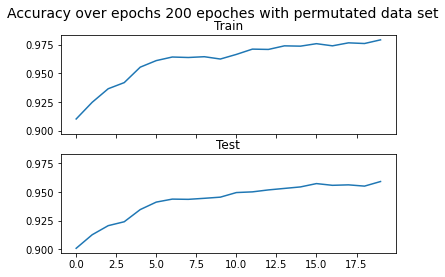

In [22]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=10)

N_TRAIN_SAMPLES = x_trainp.shape[0]
N_EPOCHS = 20
N_BATCH = 128
N_CLASSES = np.unique(y_trainp)

acc_train = []
acc_test = []

epoch = 0
while epoch < N_EPOCHS:
    random_perm = np.random.permutation(x_trainp.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        mlp.partial_fit(x_trainp[indices], y_trainp[indices], classes=N_CLASSES)
        mini_batch_index += N_BATCH
        if mini_batch_index >= N_TRAIN_SAMPLES:
            break

    acc_train.append(mlp.score(x_trainp, y_trainp))
    acc_test.append(mlp.score(x_testp, y_testp))
    epoch += 1


fig, ax = plt.subplots(2, sharex=True, sharey=True)
ax[0].plot(acc_train)
ax[0].set_title('Train')
ax[1].plot(acc_test)
ax[1].set_title('Test')
fig.suptitle("Accuracy over epochs 200 epoches with permutated data set", fontsize=14)
plt.show()

Not really a difference between the two data sets (as expected, since MLP is permutation invariant).

Now we start with 2c:<br>
Transform the data to make it ready for the CNN:

In [23]:
# normalizing the pixel values (this step helps in optimizing the performance of our model)
x_testn = np.float32((np.true_divide(x_testn, 255.0)))
x_trainn = np.float32((np.true_divide(x_trainn, 255.0)))

x_testp = np.float32((np.true_divide(x_testp, 255.0)))
x_trainp = np.float32((np.true_divide(x_trainp, 255.0)))

print(f"Shape of x_train: {x_trainn.shape}; shape of y_train: {y_trainn.shape}.")
print(f"Shape of x_test: {x_testn.shape}; shape of y_test: {y_testn.shape}.")
print(f"Shape of x_train: {x_trainp.shape}; shape of y_train: {y_trainp.shape}.")
print(f"Shape of x_test: {x_testp.shape}; shape of y_test: {y_testp.shape}.")

# converting training images into torch format
x_trainn = x_trainn.reshape(60000, 1, 28, 28)
x_trainn  = torch.from_numpy(x_trainn)
x_trainp = x_trainp.reshape(60000, 1, 28, 28)
x_trainp  = torch.from_numpy(x_trainp)

# converting test images into torch format
x_testn = x_testn.reshape(10000, 1, 28, 28)
x_testn  = torch.from_numpy(x_testn)
x_testp = x_testp.reshape(10000, 1, 28, 28)
x_testp  = torch.from_numpy(x_testp)

# converting the train target into torch format
y_trainn = y_trainn.astype(int);
y_trainn= torch.from_numpy(y_trainn)
y_trainn = y_trainn.type(torch.LongTensor)
y_trainp = y_trainp.astype(int);
y_trainp= torch.from_numpy(y_trainp)
y_trainp = y_trainp.type(torch.LongTensor)

# converting the test target into torch format
y_testn = y_testn.astype(int);
y_testn = torch.from_numpy(y_testn)
y_testn = y_testn.type(torch.LongTensor)
y_testp = y_testp.astype(int);
y_testp = torch.from_numpy(y_testp)
y_testp = y_testp.type(torch.LongTensor)

# shape of training and test data
print(f"Shape of x_trainn: {x_trainn.shape}; shape of y_trainn: {y_trainn.shape}.")
print(f"Shape of x_testn: {x_testn.shape}; shape of y_testn: {y_testn.shape}.")
print(f"Shape of x_trainp: {x_trainp.shape}; shape of y_trainp: {y_trainp.shape}.")
print(f"Shape of x_testp: {x_testp.shape}; shape of y_testp: {y_testp.shape}.")

Shape of x_train: (60000, 784); shape of y_train: (60000,).
Shape of x_test: (10000, 784); shape of y_test: (10000,).
Shape of x_train: (60000, 784); shape of y_train: (60000,).
Shape of x_test: (10000, 784); shape of y_test: (10000,).
Shape of x_trainn: torch.Size([60000, 1, 28, 28]); shape of y_trainn: torch.Size([60000]).
Shape of x_testn: torch.Size([10000, 1, 28, 28]); shape of y_testn: torch.Size([10000]).
Shape of x_trainp: torch.Size([60000, 1, 28, 28]); shape of y_trainp: torch.Size([60000]).
Shape of x_testp: torch.Size([10000, 1, 28, 28]); shape of y_testp: torch.Size([10000]).


Let us get the old code from 2c (slightly adapted):

In [24]:
# template
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class PR_CNN(nn.Module):
    def __init__(self, **kwargs):
        super(PR_CNN, self).__init__()

        self.expected_input_size = (28, 28)

        # First layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=24, kernel_size=7, stride=3),
            nn.LeakyReLU()
        )

        # Classification layer
        self.fc = nn.Sequential(
            Flatten(),
            nn.Linear(1536, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.fc(x)
        return x

# defining the model
model = PR_CNN()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.05)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()


def get_train(model, opt, silent=True, normal=True):
    def train(epoch):
        model.train()
        # getting the training set
        if normal:
            x_tr, y_tr = Variable(x_trainn), Variable(y_trainn)
        else:
            x_tr, y_tr = Variable(x_trainp), Variable(y_trainp)
        # converting the data into GPU format
        if torch.cuda.is_available():
            x_tr = x_tr.cuda()
            y_tr = y_tr.cuda()

        # clearing the Gradients of the model parameters
        opt.zero_grad()
        
        # prediction for training  set
        output_train = model(x_tr)

        # computing the training loss
        loss_train = criterion(output_train, y_tr)

        # computing the updated weights of all the model parameters
        loss_train.backward()
        opt.step()
        if epoch%2 == 0 and not silent:
            # printing the train loss
            print('Epoch : ',epoch+1, '\t', 'loss :', loss_train.detach())
    
    return train

# for the evaluation
def train_with_n_epochs(n_epochs, train):
    t = time.perf_counter()
    for e in range(n_epochs):
        train(e)
    return time.perf_counter() - t

def train_and_eval(n_epochs, normal):
    model = PR_CNN()
    optimizer = Adam(model.parameters(), lr=0.05)
    t = train_with_n_epochs(n_epochs, get_train(model, optimizer, True, normal))

    with torch.no_grad():
            if normal:
                output_train = model(x_trainn)
                output_test = model(x_testn)
            else:
                output_train = model(x_trainp)
                output_test = model(x_testp)

    predictions_test = np.argmax(
        torch.exp(output_test)
            .cpu()
            .numpy(),
        axis=1
    )
    predictions_train = np.argmax(
        torch.exp(output_train)
            .cpu()
            .numpy(),
        axis=1
    )
    if normal:
        return t, accuracy_score(y_testn, predictions_test), accuracy_score(y_trainn, predictions_train)
    else:
        return t, accuracy_score(y_testp, predictions_test), accuracy_score(y_trainp, predictions_train)

Now we can start evaluating the two different data sets:

accuracy 0.9717 for n_epochs=60 (time spent to train: 90.42 seconds)
accuracy 0.9751 for n_epochs=50 (time spent to train: 75.51 seconds)
accuracy 0.9622 for n_epochs=40 (time spent to train: 60.36 seconds)
accuracy 0.9589 for n_epochs=30 (time spent to train: 44.59 seconds)
accuracy 0.9286 for n_epochs=20 (time spent to train: 29.88 seconds)
accuracy 0.8622 for n_epochs=10 (time spent to train: 14.95 seconds)
accuracy 0.6742 for n_epochs=5 (time spent to train: 7.46 seconds)


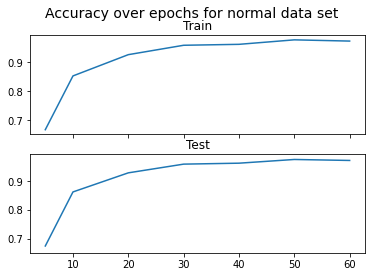

In [25]:
ns_epochs = [60, 50, 40, 30, 20, 10, 5]
accuracies = [train_and_eval(ne, True) for ne in ns_epochs]

for (t_acc, n_epochs) in zip(accuracies, ns_epochs):
    t, acc_te, acc_tr, = t_acc
    print(f"accuracy {acc_te} for n_epochs={n_epochs} (time spent to train: {round(t, 2)} seconds)")

accuracy_data_test = [acc for (_, acc, _) in accuracies]
accuracy_data_train = [acc for (_, _, acc) in accuracies]
fig, ax = plt.subplots(2, sharex=True, sharey=True)
ax[0].plot(ns_epochs, accuracy_data_train)
ax[0].set_title('Train')
ax[1].plot(ns_epochs, accuracy_data_test)
ax[1].set_title('Test')
fig.suptitle("Accuracy over epochs for normal data set", fontsize=14)
plt.show()

And the now the permutated data:

accuracy 0.943 for n_epochs=60 (time spent to train: 94.16 seconds)
accuracy 0.9296 for n_epochs=50 (time spent to train: 76.45 seconds)
accuracy 0.939 for n_epochs=40 (time spent to train: 61.0 seconds)
accuracy 0.9209 for n_epochs=30 (time spent to train: 46.47 seconds)
accuracy 0.8692 for n_epochs=20 (time spent to train: 32.06 seconds)
accuracy 0.8533 for n_epochs=10 (time spent to train: 15.43 seconds)
accuracy 0.7905 for n_epochs=5 (time spent to train: 7.77 seconds)


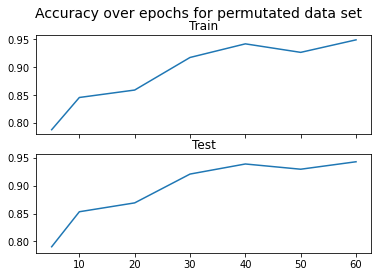

In [26]:
model = PR_CNN()
optimizer = Adam(model.parameters(), lr=0.05)

ns_epochs = [60, 50, 40, 30, 20, 10, 5]
accuracies = [train_and_eval(ne, False) for ne in ns_epochs]

for (t_acc, n_epochs) in zip(accuracies, ns_epochs):
    t, acc_te, acc_tr, = t_acc
    print(f"accuracy {acc_te} for n_epochs={n_epochs} (time spent to train: {round(t, 2)} seconds)")

accuracy_data_test = [acc for (_, acc, _) in accuracies]
accuracy_data_train = [acc for (_, _, acc) in accuracies]
fig, ax = plt.subplots(2, sharex=True, sharey=True)
ax[0].plot(ns_epochs, accuracy_data_train)
ax[0].set_title('Train')
ax[1].plot(ns_epochs, accuracy_data_test)
ax[1].set_title('Test')
fig.suptitle("Accuracy over epochs for permutated data set", fontsize=14)
plt.show()